# Kaptitel 4 - Lernen im einfachen Netz

## Perceptron-Lernalgorithmus

In [23]:
# Grahische Darstellung
import matplotlib.pyplot as plt
# Zufall
from random import choice
# Für die mathematischen Operationen
from numpy import array, dot, random, linspace, zeros
# Ganz wichtig, sonst wird der Plot nicht angezeigt
%matplotlib inline

# Trainingsdaten
# Pro Zeile: die binären Inputdaten und die gewünschte binäre Ausgabe
# in einer Liste von Tupeln.
# An der Stelle 0 des Inputvektors ist das Bias-Neuron
training_data_set = [
    (array([1,0,0]), 0),
    (array([1,0,1]), 1),
    (array([1,1,0]), 1),
    (array([1,1,1]), 1),
]

# Die Heaviside-Stufenfunktion als Lambda-Funktion
heaviside = lambda x: 0 if x < 0 else 1

# Anfangsinitialisierung des Zufallsgenerators wegen
# Reprodzierbarkei der Ergebnisse
random.seed(26) # irgendein Wert

# Array von Länge 3 mit 0 initialisieren
w = zeros(3)
# Die Anzahl der Durchläufe. Erfahrungswert durch Probieren
iterations = 100

# Start des Trainierens
def fit(iterations, training_data_set, w):
    """Lernen im Perceptron
        iterations: Ein Vorwärts- unf Rückwärtslauf aller Trainingsbeispiele
        trainings_data_set: Die Trainingsbeispiele
        w: Die Gewichte zum Starten
    """
    errors = []
    weights = []
    
    for i in range(iterations):
    # zufällige Auswahl eines Trainingsbeispiels
        training_data = choice(training_data_set)
        x = training_data[0]
        y = training_data[1]
    # Den errechneten Output ermitteln: Gewichtete Summe mit
    # nachlagerter Stufenfunktion
        y_hat = heaviside(dot(w,x))
    # Fehler berechnen als Differenz zwischen gewünschtem und 
    # aktuellen Output
        error = y - y_hat
    # Fehler sammeln für die Ausgabe
        errors.append(error)
    # Gewichte sammeln für spätere Ausgabe
        weights.append(w)
    # Gewichtsanpassung = Das Lernen... x_i ist entweder 0 oder 1
        w += error * x
    # Rückgabe der Fehler und Gewichte
    return errors, weights
    
# Trainieren
# Wir sammeln die Fehler/Gewichte in jedem Schritt für die grafische Ausgabe
errors, weights = fit(iterations, training_data_set, w)
# Den letzten Gewichtsvektor ausgeben
w = weights[iterations-1]
print("Gewichtsvektor am Ende des Trainings: ")
print((w))

# Auswertung nach den Trainieren
print("Auswertung am Ende des Trainings: ")
for x, y in training_data_set:
    y_hat = heaviside(dot(x,w))
    print("{}: {} --> {}".format(x,y,y_hat))
#------------------------------------------------------------
# Grafik für Fehler pro Lernbeispiel :-)
# Figure-Nummer Start
fignr = 1
# Druckgröße in inch
plt.figure(fignr, figsize=(10,10))
# Ausgabe Fehler als Plot
plt.plot(errors)
# Raster
plt.style.use('seaborn-whitegrid')
# Labels
plt.xlabel('Iterationen')
plt.ylabel(r"$(y - \hat y)$")

Gewichtsvektor am Ende des Trainings: 
[-1.  1.  1.]
Auswertung am Ende des Trainings: 
[1 0 0]: 0 --> 0
[1 0 1]: 1 --> 1
[1 1 0]: 1 --> 1
[1 1 1]: 1 --> 1


Text(0, 0.5, '$(y - \\hat y)$')

## Scikit-Learn kompatibler Estimator

[1 0 0]: 0 -> 0
[1 0 1]: 1 -> 1
[1 1 0]: 1 -> 1
[1 1 1]: 1 -> 1


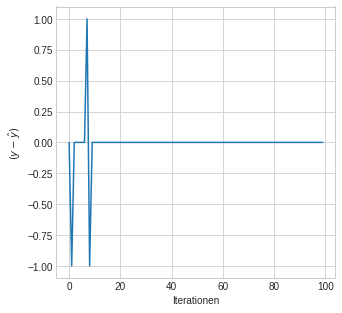

In [27]:
# Numpy hilft uns mit den arrays
import numpy as np
# Das sind unsere Basisklassen
from sklearn.base import BaseEstimator, ClassifierMixin
# Prüfroutinen für die Konsistenz der Daten, etc.
from sklearn.utils.validation import check_X_y, check_is_fitted, check_random_state
# Puffern der unterschiedlichen Zielwerte
from sklearn.utils.multiclass import unique_labels
# Ganz wichtig, sonst wird der Plot nicht angezeigt
%matplotlib inline

# Unser Estimator, passend bezeichnet und die Basisklassen
class PerceptronEstimator(BaseEstimator, ClassifierMixin):
    # Initialisierung
    def __init__(self, n_iterations=20, random_state=None):
        """ Initialisierung der Objekte
        
        n_iterations: Anzahl der Iterationen für das Lernen
        random_state: Um Wiederholbarkeit zu garantieren sollte ein 
                      numpy.random.RandomState Objekt konstruiert werden, 
                      das mit random_state Seed initialisiert wurde
        
        """
        # Die Anzahl der Iterationen        
        self.n_iterations = n_iterations
        # Die Seed für den Zufallsgenerator
        self.random_state = random_state
        # Die Fehler im Lernprozeß für den Plot gepuffert
        self.errors = []

    # Eine Stufenfunktion, benannt nach dem Mathematiker und Physiker 
    # Oliver Heaviside
    def heaviside(self, x):
        """ Eine Stufenfunktion
        
        x: Der Wert für den die Stufenfunktion ausgewertet wird 
        
        """ 
        if x < 0:
            result = 0
        else:
            result = 1
        return result
    
    # Lernen
    def fit(self, X=None, y=None ):
        """ Trainieren
        
        X: Array-ähnliche Struktur mit [N,D], wobei 
           N = Zeilen = Anzahl der Lernbeispiele und 
           D = Spalten = Anzahl der Features 
        y: Array mit [N], mit N so wie oben
        
        """ 
        # Erzeugung des Zufallsgenerators (RNG)
        self.random_state_ = check_random_state(self.random_state)
        # Gewichtinitialisierung
        # np.size(.,1) = Anzahl der Spalten
        self.w = self.random_state_.random_sample(np.size(X,1)) 
        
        # Prüfe, ob X und y die korrekte shape haben: X.shape[0] = y.shape[0]
        X, y = check_X_y(X, y)
        # Die eindeutigen Zielwerte speichern
        self.classes_ = unique_labels(y)
        # Lerndaten für spätere Prüfung in Methode predict speichern
        self.X_ = X
        self.y_ = y      
        # Lernen 
        for i in range(self.n_iterations):
            # zufälliges durchwürfeln, für batch size = 1     
            # np.size(.,0) = Anzahl der Zeilen
            rand_index = self.random_state_.randint(0,np.size(X,0))
            # Ein zufälliger Inputvektor
            x_ = X[rand_index]
            # Ein dazu passender Output
            y_ = y[rand_index]
            # Den errechneten Output ermitteln: 
            # Gewichtete Summe mit nachgelagerter Stufenfunktion
            y_hat = self.heaviside(dot(self.w, x_))
            # Fehler berechnen als Differenz zwischen gewünschtem und 
            # aktuellem Output    
            error = y_ - y_hat
            # Fehler sammeln für die Ausgabe    
            self.errors.append(error)
            # Gewichtsanpassung = Das Lernen   
            self.w += error * x_
            # Rückgabe des Estimators für verknüpfte Aufrufe
        return self
    
    # Auswerten
    def predict(self, x):
        """ Auswerten eines Vektors
        
        x: Ein Test Inputvektor 
        
        """   
        # Prüfen, ob fit berereits aufgerufen wurde
        # Die Daten wurden in der Methode fit gesetzt
        check_is_fitted(self, ['X_', 'y_'])
        # Auswerten, Forward Path
        y_hat = self.heaviside(dot(self.w,x))

        return y_hat
    
    # Plot
    def plot(self):
        """ Ausgabe des Fehlers
        
        Die im Fehlerarray gespeicherten Fehler als Grafik ausgeben
        
        """         
        # Figure Nummern Start
        fignr = 1
        # Druckgröße in inch
        plt.figure(fignr,figsize=(5,5))
        # Ausgabe Fehler als Plot
        plt.plot(self.errors)
        # Raster
        plt.style.use('seaborn-whitegrid')  
        # Labels
        plt.xlabel('Iterationen')
        plt.ylabel(r"$(y - \hat y)$")


# Trainingsdaten
X = np.array([[1,0,0], [1,0,1], [1,1,0],[1,1,1]])
y = np.array([0,1,1,1])
# Lernen
Perceptron = PerceptronEstimator(20,10) # 20=iterations, 10=random_state
Perceptron.fit(X,y) 
# Testdaten
x = np.array([1,0,0])
# Auswertung
for index, x in enumerate(X):
    p = Perceptron.predict(x)
    print("{}: {} -> {}".format(x, y[index],p))
# Graph ausgeben    
Perceptron.plot()

## Scikit-Learn Perceptron

In [47]:
# Scikit-Learn Perceptron
import numpy as np
# Das bereits bekannte Iris Dataset
from sklearn.datasets import load_iris
# Ladies and Gentlemen – Das Perceptron
from sklearn.linear_model import Perceptron
# Den Iris Datensatz laden
iris = load_iris()
# Die Eingabevektoren für das Lernen.
# 150 Vektoren mit 5 Spalten
X = iris.data[:,(2,3)] # petal length, petal width
# Die gewünschten Werte 
y = iris.target
# Das Perceptron instanziieren
# random_state = Seed für Zufallsgenerator
# max_iter = Maximale Anzahl an Iterationen
# tol = Stoppkriterium
Perceptron = Perceptron(random_state=49,max_iter=1000000,tol=None)
# Lernen bitte
Perceptron.fit(X,y)
# und auswerten: Iris-setosa, Iris-versicolor, Iris-virginca
y_prediction = Perceptron.predict([ [1.4,0.2], [3.5,0.4], [6.0,2.5]])
# natürlich die Ausgabe nicht vergessen
print(y_prediction)

[0 1 2]


## Adaline

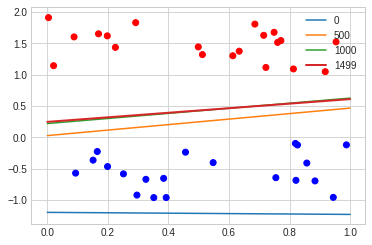

In [26]:
from sklearn.base import BaseEstimator, ClassifierMixin
# Prüfroutinen 
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state
# Speichern 
from sklearn.utils.multiclass import unique_labels
# Ganz wichtig, sonst wird der Plot nicht angezeigt
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from random import choice
import math
import sympy

class AdalineEstimator(BaseEstimator, ClassifierMixin):
    # Init    
    def __init__(self, eta=.001, n_iterations=500, random_state=None):
        """ Initialisierung der Objekte
        
        eta:          Lernrate
        n_iterations: Anzahl der Iterationen für das Lernen
        random_state: Um Wiederholbarkeit zu garantieren sollte ein numpy.random.RandomState Objekt 
                      konstruiert werden, das mit random_state Seed initialisiert wurde
        batch:        Batchlernen anwenden?
        
        """
        # Die Anzahl der Iterationen   
        self.n_iterations = n_iterations
        # Die Lernrate    
        self.eta = eta
        # Die Seed für den Zufallsgenerator
        self.random_state = random_state
        # Die Fehler im Lernprozeß
        self.errors = []
        # Gewichte für die Berechnung im KNN
        self.w = []
        # Alle Gewichte für Plot, zum Zeichnen der Trenngeraden     
        self.wAll = []
    # Der gewichtete Input       
    def net_i(self, x):
        """ Den gewichteten Input w*x berechnen
      
          x: Ein Vektor
        """
        return np.dot(x, self.w)
    # Aktivierungsfunktion, so wie im Kapitel 1 besprochen
    def activation(self, x):
        """ Lineare Aktivierungsfunktion
      
        """
        return self.net_i(x)
    # Outputfunktion, wobei der Output 1 und -1 sein kann 
    # im Gegensatz zum Perceptron, wo 1 und 0 ausgegeben werden
    def output(self, x):
        """ Outputfunktion
      
        """
        if self.activation(x) >= 0.0:
            return 1
        else:
            return -1
        
    # Lernen
    def fit(self, X=None, y=None):
        """ Trainieren
        
        X: Array-ähnliche Struktur mit [N,D], wobei 
           N = Zeilen = Anzahl der Lernbeispiele und 
           D = Spalten = Anzahl der Features 
        y: Array mit [N], mit N so wie oben
        
        """ 
        # Erzeugung des Zufallsgenerators (RNG)
        self.random_state_ = check_random_state(self.random_state)        
        # Gewichtinitialisierung
        self.w = self.random_state_.random_sample(np.size(X,1)) # np.size(.,1) = Anzahl der Spalten
        # Prüfe, ob X und y die korrekte Shape haben: X.shape[0] = y.shape[0]
        X, y = check_X_y(X, y)
        # Lerndaten für spätere Verwendung ablegen
        self.X_ = X
        self.y_ = y      
        # Lernen mit Gradientenabstieg 
        for i in range(self.n_iterations):
        # Optimales zufälliges durchwürfeln, für batch size = 1     
            rand_index = self.random_state_.randint(0,np.size(X,0)) # np.size(.,0) = Anzahl der Zeilen
            # Ein zufälliger Inputvektor
            x_ = X[rand_index]
            # Ein dazu passender Output (+1,-1)
            y_ = y[rand_index]
            # net input berechnen
            net_j = np.dot(x_, self.w)
            # Fehler zwischen gewünschem Output und net input
            error = (y_ - net_j)**2
            self.errors.append(error)
            # Online Learning
            for j in range(3):
                weight = {}
                self.w[j] += self.eta * x_[j] * (y_ - net_j) 
                weight[0] = self.w[0]
                weight[1] = self.w[1]
                weight[2] = self.w[2]
                self.wAll.append(weight) # 3 * nr_iterations
    # Auswerten                
    def predict(self,x):
        """ Auswerten eines Vektors
        
        x: Ein Test Inputvektor 
        
        """   
        # Prüfen, ob fit gerufen wurde
        check_is_fitted(self, ['X_', 'y_'])
        
        return self.output(x)       
    # Anzeigen        
    def plot(self):
        x1 = []
        x2 = []
        colors = []
        
        for i in range(self.X_.shape[0]):
            x1.append(self.X_[i][1])
            x2.append(self.X_[i][2])
            y = self.y_[i]
            if y == 1:
                colors.append('r') # rot
            else:
                colors.append('b') # blau
        # Errors
        plt.plot(self.errors)        
        # Learning Curve
        plt.figure(1)    
        plt.show()
        # Scatter
        plt.figure(2)
        plt.scatter(x1, x2,c=colors)  
        # Result Line
        x1Line = np.linspace(0.0, 1.0, 2)
        x2Line = lambda x1, w0, w1, w2: (-x1*w1 - w0) / w2;
        alpha = 0.0
        for idx, weight in enumerate(self.wAll):
            # alpha = Transparenz, je näher zum Ziel desto dünkler
            if (idx % 500 == 0):
                alpha = 1.0 #( idx / len(self.wAll) )
                plt.plot(x1Line, x2Line(x1Line,weight[0],weight[1],weight[2]), alpha=alpha , linestyle='solid', label=str(idx), linewidth=1.5)      
        # Ergebnisgerade 
        plt.plot(x1Line, x2Line(x1Line,weight[0],weight[1],weight[2]), alpha=alpha , linestyle='solid', label=str(idx), linewidth=2.0)  
        plt.legend(loc='best', shadow=True)
        
### MAIN ###
# Erzeugung des Zufallsgenerators (RNG)
random_state = check_random_state(10)        
# Initialisierung
I = []
o = []
# Datensatz aufbauen 
for x in random_state.random_sample(20):
    y = random_state.random_sample()
    I.append([1, x, y+1.0]) # Falls +0.0, dann überlappende Mengen
    o.append(1)
        
for x in random_state.random_sample(20):
    y = random_state.random_sample()
    I.append([1, x, y-1.0]) # Falls +0.0, dann überlappende Mengen
    o.append(-1)

# numpy array bauen
X = np.array(I)
y = np.array(o)
# Walte deines Amtes Estimator
Adaline = AdalineEstimator(eta=0.01,n_iterations=500, random_state=10)
Adaline.fit(X,y)
Adaline.plot()